In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy 
import theano
from sklearn.metrics import mean_squared_error
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
from random import seed
import scipy.optimize as opt
plt.style.use("seaborn-darkgrid")
from pymc3.distributions.timeseries import EulerMaruyama

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import datetime
import pandas as pd
import plotly.express as px
import scipy 
px.defaults.height=600

In [3]:
# From now on we'll work with proportions instead of integer numbers
# i -> infectados/N
# Parameters: 
# beta = disease transmission rate
# gamma = recovery rate
# mu = mortality rate
# mu + beta = renewal rate
# theta = [beta - (mu+gamma), beta]
# Thus, if theta[0]<0, the disease will vanish and if theta[0]>0 we have persistence of the disease

i0 = 0.2 # initial proportion of infected
Tf = 20 # Terminal time
T0 = 0 # Initial time
Dt = 0.25 # time step
beta, gamma, mu, sigma =  0.7, 0.4, 0.65,0.842  #add a known sigma to be able to estimate the true value 
theta= np.asarray([beta - (mu+gamma), beta,sigma])
times = np.arange(T0, Tf, Dt) # time vector
theta_t=theta
R_0 = 1+(theta[0]-0.5*theta[2]**2)/(theta[1]-theta[0])
R_0

0.32906476190476186

In [4]:
if R_0 > 1:
    print('la enfermedad persiste')
else: 
    if theta[2]**2 <= theta[1]:
        print('la enfermedad se extingue')


if theta[2]**2 > theta[1]*max(1,(0.5*theta[1])/(theta[1]-theta[0])):
    print('la enfermedad se extingue')

la enfermedad se extingue


#### Equation of the stochastic sis model

$$     \frac{dI_{t}}{dt} =I_t([\beta N-\mu-\gamma-\beta I_t]dt + \sigma (N-I_t)dB_t) $$

$$ \frac{dI_{t}}{dt} = \left[I_t \left((\beta -\mu -\gamma) - \frac{\beta I_t}{N}\right)\right]dt + \sigma \left( I_t - \frac{I_t^2}{N}\right) dB_t $$
$$ \frac{dI_{t}}{Ndt} = \left[\frac{I_t}{N} \left((\beta -\mu -\gamma) - \frac{\beta I_t}{N}\right)\right]dt + \sigma \left( \frac{I_t}{N} - \frac{I_t^2}{N^2}\right) dB_t $$
$$ \frac{dI_{t}}{Ndt} = \left[\frac{I_t}{N} \left((\beta -(\mu +\gamma)) - \frac{\beta I_t}{N}\right)\right]dt + \sigma \left( \frac{I_t}{N} - \frac{I_t^2}{N^2}\right) dB_t $$

#### Euler-Maruyama
$$ X(t_{i+1})=X(t_i)+ b(X(t_i)) \Delta t+B(X(t_i))\Delta W_i  $$
for all $i=0,1,2,...,N-1$ with the initial condition $X(t_0)=X_0$, $\Delta W_i\sim N(0,\Delta t)$.

In [5]:

seed(991103)
# time series
N = len(times)-1
x = i0 # initial proportion of infected 
x_t = []

# simulate
for i in range(N):
    x = x + (x*(theta[0]-(x*theta[1])))*Dt + theta[2] * (x-x**2) * np.random.normal()*np.sqrt(Dt)
    x_t.append(x)
x_t = np.array(x_t) # convert the values into an array
x_t=np.insert(x_t,0,i0,axis=0) # add the initial condition at the beginning of the array


Text(0, 0.5, 'Proporción')

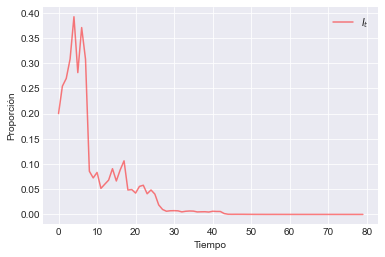

In [6]:
# Plotting the Euler-Maruyama process
plt.plot(x_t, "r", label=r"$I_t$", alpha=0.5)
plt.xlabel("Tiempo")
plt.legend()
plt.ylabel("Proporción")

In [7]:
# ODEs model
def SISS(i, theta):
    di = (i*(theta[0]-theta[1]*i)) 
    sigma1 =  theta[2] *( i-i**2)
    return di, sigma1

In [8]:
# Define pymc model and sampling the MC Markov chain
nb_chains = 2 #choose >1 to run some convergence diagnostics on the chains
len_chains = 15000
len_burning_states = 5000

with pm.Model() as model:
    theta_m = [0,0,0]
    theta_m[0] = pm.Cauchy("beta-(mu+gamma)", -3,1) 
    theta_m[1] = pm.Gamma("beta",3,1) 
    theta_m[2] = pm.HalfNormal("sigma",0.5) # pm.Bound(pm.Normal, lower=0)("sigma",0,1)
    eu = EulerMaruyama("EM", Dt, SISS, (theta_m,),shape=x_t.shape, observed=x_t)

In [9]:
with model:
    trace = pm.sample(len_chains, tune=len_burning_states, cores=1, chains=nb_chains)
    data = az.from_pymc3(trace=trace)

C:\Users\sebas\AppData\Local\Temp\ipykernel_18940\2155683141.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(len_chains, tune=len_burning_states, cores=1, chains=nb_chains)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, beta-(mu+gamma)]


Sampling 2 chains for 5_000 tune and 15_000 draw iterations (10_000 + 30_000 draws total) took 20 seconds.


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


In [10]:
a=az.summary(trace)
a

Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta-(mu+gamma),-0.241,0.157,-0.519,0.065,0.001,0.001,19833.0,16960.0,1.0
beta,1.354,0.652,0.220,2.533,0.005,0.003,19054.0,15378.0,1.0
sigma,0.694,0.056,0.593,0.800,0.000,0.000,24507.0,19096.0,1.0


In [11]:
theta_t

array([-0.35 ,  0.7  ,  0.842])

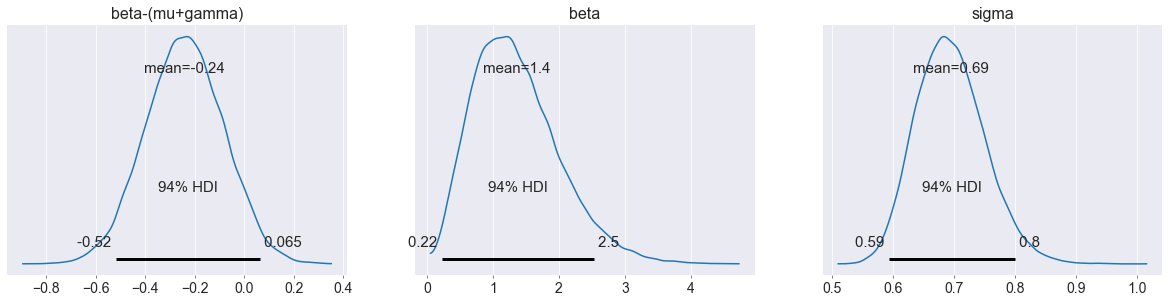

In [12]:
# Plot posterior densities
az.plot_posterior(data, 
                  var_names=["beta-(mu+gamma)", "beta","sigma"]);
plt.show()

Text(0, 0.5, 'MCMC promedio')

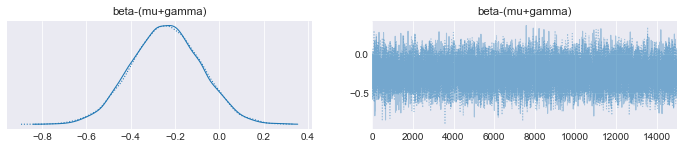

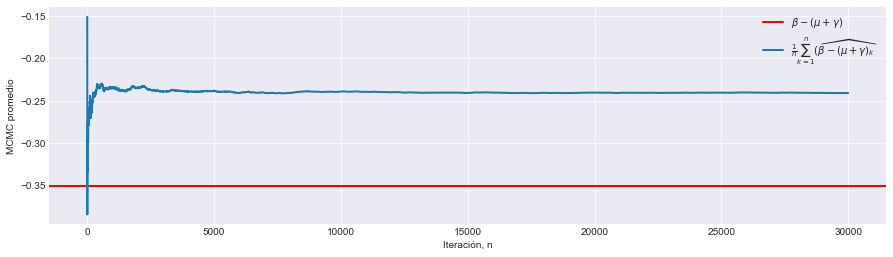

In [13]:
# plot the exploration for each chain and convergence of the ergodic mean
# beta - (mu+gamma)
az.plot_trace({"beta-(mu+gamma)": trace.get_values(varname="beta-(mu+gamma)", combine=False)})
mean_theta0 = [np.mean(trace['beta-(mu+gamma)'][:i]) for i in np.arange(1, len(trace['beta-(mu+gamma)']))]
plt.figure(figsize=(15, 4))
plt.axhline([theta_t[0]], lw=2, color="red", label=r"$\beta-(\mu+\gamma)$")
plt.plot(mean_theta0, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{(\beta-(\mu+\gamma)}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

Text(0, 0.5, 'MCMC promedio')

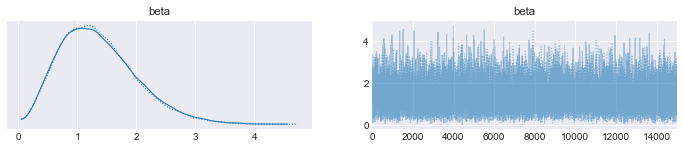

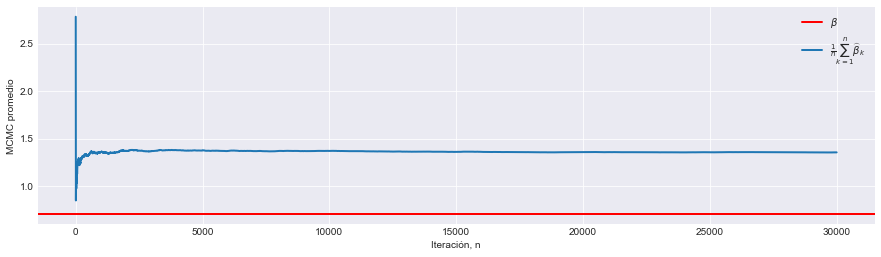

In [14]:
# beta
az.plot_trace({"beta": trace.get_values(varname="beta", combine=False)})
mean_theta1 = [np.mean(trace['beta'][:i]) for i in np.arange(1, len(trace['beta']))]
plt.figure(figsize=(15, 4))
plt.axhline([theta_t[1]], lw=2, color="red", label=r"$\beta$")
plt.plot(mean_theta1, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{\beta}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

Text(0, 0.5, 'MCMC promedio')

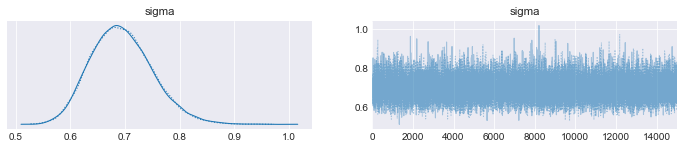

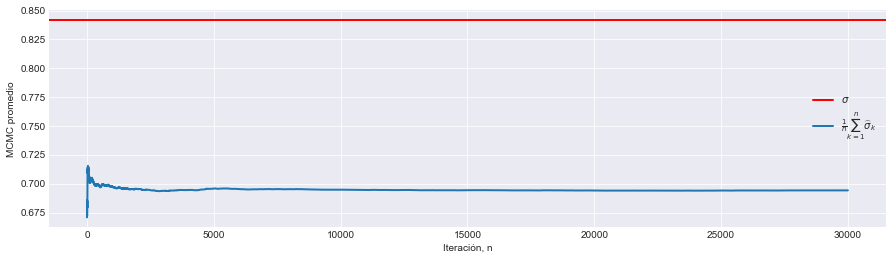

In [15]:
# sigma
az.plot_trace({"sigma": trace.get_values(varname="sigma", combine=False)})
mean_theta2 = [np.mean(trace['sigma'][:i]) for i in np.arange(1, len(trace['sigma']))]
plt.figure(figsize=(15, 4))
plt.axhline([theta_t[2]], lw=2, color="red", label=r"$\sigma$")
plt.plot(mean_theta2, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{\sigma}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

In [16]:
theta_est = [mean_theta0[-1],mean_theta1[-1],mean_theta2[-1]]

R_0 = 1+(theta_est[0]-0.5*theta_est[2]**2)/(theta_est[1]-theta_est[0])
R_0
if R_0 > 1:
    print('la enfermedad persiste')
else: 
    if theta_est[2]**2 <= theta_est[1]:
        print('la enfermedad se extingue')


if theta_est[2]**2 > theta_est[1]*max(1,(0.5*theta_est[1])/(theta_est[1]-theta_est[0])):
    print('la enfermedad se extingue')

la enfermedad se extingue


In [17]:
theta

array([-0.35 ,  0.7  ,  0.842])

In [18]:
theta_est

[-0.24106916683189775, 1.3539548427620431, 0.6941681810592821]

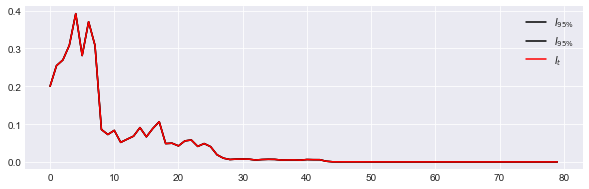

In [19]:
# generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace, model=model)

# plot with data
plt.figure(figsize=(10, 3))
plt.plot(np.percentile(ppc_trace["EM"], [2.5, 97.5], axis=0).T, "k", label=r"$I_{95\%}$")
plt.plot(x_t, "r", label=r"$I_t$")
plt.legend()

In [20]:
simga_2_ep = sum(np.diff(x_t)**2)/(Dt*sum((x_t**2)+(1-x_t)**2))
np.sqrt(simga_2_ep)

0.07084910496211609

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Nov 01 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

plotly    : 5.10.0
scipy     : 1.7.3
theano    : 1.1.2
pymc3     : 3.11.4
sys       : 3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]
numpy     : 1.22.3
matplotlib: 3.5.1
pandas    : 1.4.3
arviz     : 0.12.1

Watermark: 2.3.1

